In [7]:
from typing import TypedDict, Dict, List, Any, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

In [8]:
import os
import getpass
def setup_environment():
    """Setup your API KEYs"""
    if not os.environ.get("OPENAI_API_KEY"):
        openai_key = getpass.getpass("Enter your OPENAI API KEY")
        os.environ["OPENAI_API_KEY"] = openai_key
print("Setup Complete")
setup_environment()

Setup Complete


In [17]:
class State(TypedDict):
    messages: Annotated[List, add_messages]

In [50]:
def small_talk_node(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini")
    user_message = state['messages'][-1]
    response = llm.invoke([user_message])
    return {'messages': [response]}

In [51]:
def calculator_node(state: State):
    user_message = state['messages'][-1].content
    try:
        result = str(eval(user_message))
    except:
        result = "I can't calculate that"
    reply = AIMessage(content=result)
    return {"messages": [reply]}

In [52]:
def route(state: State):
    text = state['messages'][-1].content.lower()
    if any(word in text for word in ["+", "-", "*", "/", "calculate"]):
        return "calculator"
    else:
        return "small_talk"

In [58]:
graph = StateGraph(State)

graph.add_node("router", route)
graph.add_node("small_talk", small_talk_node)
graph.add_node("calculator", calculator_node)

# graph.add_edge(START, "router")

graph.add_conditional_edges(
    START,                      
    route,                        
    {"calculator": "calculator", "small_talk": "small_talk"}   
)


graph.add_edge("small_talk", END)
graph.add_edge("calculator", END)

app = graph.compile()

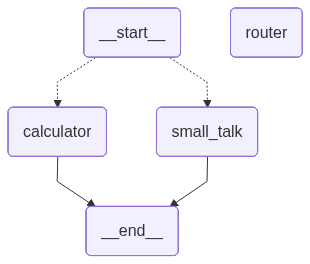

In [59]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [60]:
state: State = {
    "messages": [HumanMessage(content="Hello, who are you?")],
}
state = app.invoke(state)
print("\n--- Response 1 ---")
for m in state["messages"]:
    print(m.__class__.__name__, ":", m.content)

# Math question
state["messages"].append(HumanMessage(content="2 + 3 * 4"))
state = app.invoke(state)
print("\n--- Response 2 ---")
for m in state["messages"][-2:]:
    print(m.__class__.__name__, ":", m.content)


--- Response 1 ---
HumanMessage : Hello, who are you?
AIMessage : Hello! I’m an AI language model created by OpenAI, here to assist you with information, answer questions, and help with a variety of topics. How can I assist you today?

--- Response 2 ---
HumanMessage : 2 + 3 * 4
AIMessage : 14
